In [1]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/triyuliannibasukie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseV

In [2]:
tweets = pd.read_csv('2022 Twitter Tweets Jan-April_Amber Heard Data.csv')
tweets.head()

,id_str,created_at,full_text,lang,in_reply_to_status_id_str,in_reply_to_user_id,entities.hashtags,entities.media,entities.symbols,entities.urls,...,user.friends_count,user.lang,user.location,user.name,user.screen_name,user.profile_banner_url,user.profile_image_url,user.statuses_count,user.url,user.verified
0,1477504983130116096.0,2022-01-02 05:00:13+00:00,@la77465262 @Melinda15199317 @Dior So why is #...,en,1466075642244603909,1363630915298148352.0,"[{'indices': [45, 56], 'text': 'JohnnyDepp'}]","[{'original_info': {'width': 1058, 'focus_rect...",[],[],...,1898.0,NaN,NaN,Sean O'Connor,seano999,https://pbs.twimg.com/profile_banners/11497951...,http://pbs.twimg.com/profile_images/1442389537...,27033.0,NaN,False
1,1477503751716065280.0,2022-01-02 04:55:19+00:00,Only thing I want them to leave alone is the f...,en,NaN,NaN,[],NaN,[],[],...,1025.0,NaN,NaN,❤️‍🔥 Wilson the Opp Slayer 🔪,WonderWilson18,https://pbs.twimg.com/profile_banners/14262271...,http://pbs.twimg.com/profile_images/1515742990...,27853.0,https://t.co/dVvgQNht1k,False
2,1477499814719983616.0,2022-01-02 04:39:41+00:00,@soldierboy43001 @ZakReckless Yeah but Snyder ...,en,1477497121972621318,1297204830231040000.0,[],NaN,[],[],...,139.0,NaN,NaN,Steven Curry,StevenJCurry,https://pbs.twimg.com/profile_banners/14273589...,http://pbs.twimg.com/profile_images/1429534379...,199.0,NaN,False
3,1477497740498292736.0,2022-01-02 04:31:26+00:00,@IIMissMax @bg98021 @GerberKawasaki You forgot...,en,1477475212992073728,305017078.0,[],NaN,[],[],...,128.0,NaN,NaN,Vincent 1,Vincent72516869,NaN,http://pbs.twimg.com/profile_images/1354614785...,2313.0,NaN,False
4,1477496477484212224.0,2022-01-02 04:26:25+00:00,I never seen Aquaman nor will I because Amber ...,en,NaN,NaN,[],NaN,[],[],...,141.0,NaN,𝗡𝗢𝗧 𝗦𝗣𝗢𝗜𝗟𝗘𝗥 𝗙𝗥𝗘𝗘,𝐇𝐘𝐃𝐄,YoonJaysSimp,https://pbs.twimg.com/profile_banners/10769432...,http://pbs.twimg.com/profile_images/1516751870...,5423.0,https://t.co/XkBVR5FDCS,False


In [3]:
df = tweets.filter(['full_text', 'lang', "created_at"], axis=1)
df1 = df[df["lang"] == "en"]
df_jan = df1[(df1['created_at'] > '2022-01-01') & (df1['created_at'] < '2022-02-01')]
df2 = df_jan.dropna()
df2.head()

,full_text,lang,created_at
0,@la77465262 @Melinda15199317 @Dior So why is #...,en,2022-01-02 05:00:13+00:00
1,Only thing I want them to leave alone is the f...,en,2022-01-02 04:55:19+00:00
2,@soldierboy43001 @ZakReckless Yeah but Snyder ...,en,2022-01-02 04:39:41+00:00
3,@IIMissMax @bg98021 @GerberKawasaki You forgot...,en,2022-01-02 04:31:26+00:00
4,I never seen Aquaman nor will I because Amber ...,en,2022-01-02 04:26:25+00:00


# Data cleaning

In [4]:
# Remove non-English words

# remove hashtags 
df2['clean_text']  = df2['full_text'].map(lambda x: re.sub("#[A-Za-z0-9_]+", " ", str(x)))

# remove mentions
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("@[A-Za-z0-9_]+"," ", str(x)))

# remove links
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub(r"http\S+"," ", str(x)))

# remove "&amp"
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("&amp"," ", str(x)))

# remove punc 
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))

# lower case
df2['clean_text']  = df2['clean_text'].apply(lambda x: x.lower())

# remove amber heard and johnny depp
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("amber","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("heard","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("johnny","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("depp","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("ah","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("jd","", str(x)))

# tokenize
df2['clean_text']  = [word_tokenize(row) for row in df2['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df2['clean_text']  = df2['clean_text'].apply(lambda x: remove_stopwords(x))

In [5]:
df2.head()

,full_text,lang,created_at,clean_text
0,@la77465262 @Melinda15199317 @Dior So why is #...,en,2022-01-02 05:00:13+00:00,"[bringing, civil, case, knows, evidence, stand..."
1,Only thing I want them to leave alone is the f...,en,2022-01-02 04:55:19+00:00,"[thing, want, leave, alone, first, wonder, wom..."
2,@soldierboy43001 @ZakReckless Yeah but Snyder ...,en,2022-01-02 04:39:41+00:00,"[ye, snyder, involved, flash, would, care]"
3,@IIMissMax @bg98021 @GerberKawasaki You forgot...,en,2022-01-02 04:31:26+00:00,"[forgot, hook, sure, find, someone, stress]"
4,I never seen Aquaman nor will I because Amber ...,en,2022-01-02 04:26:25+00:00,"[never, seen, aquaman]"


In [6]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df2['clean_text'] = df2['clean_text'].apply(lambda x: lemmatization(x))


df2.head()

,full_text,lang,created_at,clean_text
0,@la77465262 @Melinda15199317 @Dior So why is #...,en,2022-01-02 05:00:13+00:00,"[case, evidence, court, money, reputation, fau..."
1,Only thing I want them to leave alone is the f...,en,2022-01-02 04:55:19+00:00,"[thing, wonder, woman, movie, phase, aquaman, ..."
2,@soldierboy43001 @ZakReckless Yeah but Snyder ...,en,2022-01-02 04:39:41+00:00,"[ye, snyder, flash]"
3,@IIMissMax @bg98021 @GerberKawasaki You forgot...,en,2022-01-02 04:31:26+00:00,[stress]
4,I never seen Aquaman nor will I because Amber ...,en,2022-01-02 04:26:25+00:00,[aquaman]


In [7]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df2['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


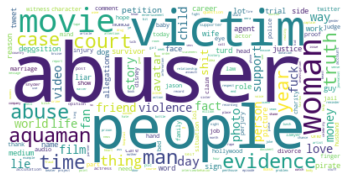

In [8]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

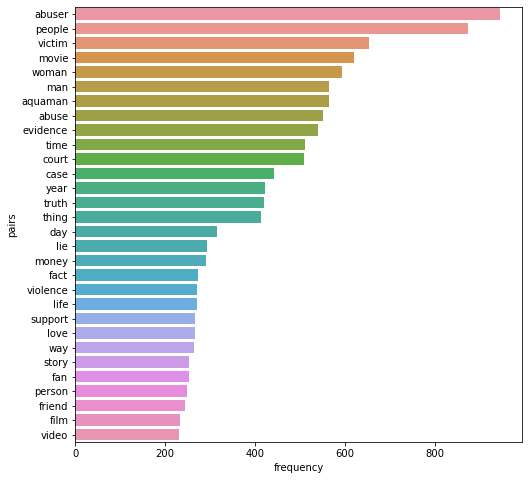

In [9]:
new_tokens = []
for i in df2["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [10]:
data_lemmatized = df2['clean_text'].tolist()
print(data_lemmatized[:3])

[['case', 'evidence', 'court', 'money', 'reputation', 'fault', 'bringing', 'case', 'stan', 'waste', 'time'], ['thing', 'wonder', 'woman', 'movie', 'phase', 'aquaman', 'film'], ['ye', 'snyder', 'flash']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'bringing'), (1, 'case'), (2, 'court'), (3, 'evidence'), (4, 'fault'), (5, 'money'), (6, 'reputation'), (7, 'stan'), (8, 'time'), (9, 'waste'), (10, 'aquaman'), (11, 'film'), (12, 'movie'), (13, 'phase'), (14, 'thing'), (15, 'woman'), (16, 'wonder'), (17, 'flash'), (18, 'snyder'), (19, 'ye'), (20, 'stress'), (21, 'name'), (22, 'think'), (23, 'art'), (24, 'fan'), (25, 'bestie'), (26, 'boycott'), (27, 'receipt'), (28, 'abuser'), (29, 'myth'), (30, 'relationship'), (31, 'reminder'), (32, 'support'), (33, 'drop'), (34, 'deal'), (35, 'housekeeper'), (36, 'attention'), (37, 'authority'), (38, 'celebrity'), (39, 'dog'), (40, 'fact'), (41, 'other'), (42, 'perjury'), (43, 'heat'), (44, 'house'), (45, 'load'), (46, 'night'), (47, 'self'), (48, 'truck'), (49, 'water')]

Total Vocabulary Size: 2958


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [13]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [14]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.36741119799766575
Perplexity Score:  -6.911520070714386

topic number:  3
Coherence Score:  0.38261415414208316
Perplexity Score:  -6.979532849240616

topic number:  4
Coherence Score:  0.36410734399482236
Perplexity Score:  -7.049995876260363

topic number:  5
Coherence Score:  0.3129557972190368
Perplexity Score:  -7.081274723200595

topic number:  6
Coherence Score:  0.318112322563138
Perplexity Score:  -7.131677843618652

topic number:  7
Coherence Score:  0.3251189028304391
Perplexity Score:  -7.1727366283534915

topic number:  8
Coherence Score:  0.3221958148984929
Perplexity Score:  -7.194801216382673

topic number:  9
Coherence Score:  0.35741705638228605
Perplexity Score:  -7.212480907923178

topic number:  10
Coherence Score:  0.362287329851326
Perplexity Score:  -7.228981490817248

topic number:  11
Coherence Score:  0.3616548565433963
Perplexity Score:  -7.271403398895016

topic number:  12
Coherence Score:  0.3629205950409506
Perplexity

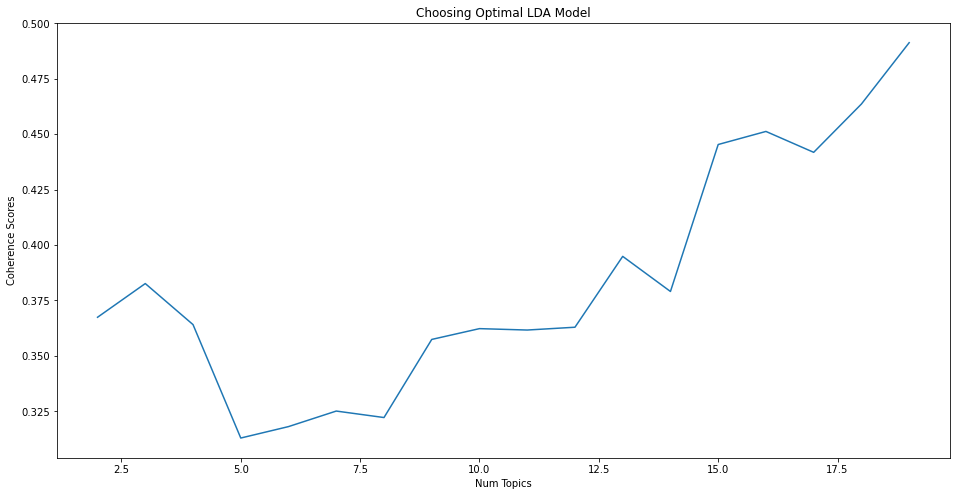

In [15]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [16]:
ntopics_des_name = 3

# We choose 3 because it has the highest coherence score reached before a major drop.

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [17]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.031*"court" + 0.027*"truth" + 0.019*"time" + 0.016*"fan" + 0.015*"video" '
  '+ 0.012*"petition" + 0.011*"agent" + 0.010*"day" + 0.010*"sign" + '
  '0.010*"aquaman"'),
 (1,
  '0.039*"movie" + 0.039*"people" + 0.027*"aquaman" + 0.016*"person" + '
  '0.015*"love" + 0.014*"avatar" + 0.014*"thing" + 0.013*"support" + '
  '0.013*"fuck" + 0.013*"time"'),
 (2,
  '0.046*"abuser" + 0.031*"victim" + 0.028*"woman" + 0.026*"abuse" + '
  '0.024*"evidence" + 0.020*"man" + 0.019*"case" + 0.014*"lie" + '
  '0.013*"violence" + 0.013*"life"')]


In [18]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [19]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df2)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [20]:
df2['Topic'] = topic_num

In [21]:
des_name_final = df2[['full_text', 'clean_text', 'Topic']]
des_name_final.head()

,full_text,clean_text,Topic
0,@la77465262 @Melinda15199317 @Dior So why is #...,"[case, evidence, court, money, reputation, fau...","[0, 2, 1]"
1,Only thing I want them to leave alone is the f...,"[thing, wonder, woman, movie, phase, aquaman, ...","[1, 2, 0]"
2,@soldierboy43001 @ZakReckless Yeah but Snyder ...,"[ye, snyder, flash]","[1, 0, 2]"
3,@IIMissMax @bg98021 @GerberKawasaki You forgot...,[stress],"[0, 2, 1]"
4,I never seen Aquaman nor will I because Amber ...,[aquaman],"[1, 0, 2]"


### Model Evaluation

In [22]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.979912799381902
Coherence Score:  0.38037920198638603


## Visualisation

In [23]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.212518  0.196416       1        1  39.586411
1      0.075402 -0.270543       2        1  30.784072
0     -0.287920  0.074127       3        1  29.629517, topic_info=        Term        Freq       Total Category  logprob  loglift
28    abuser  914.000000  914.000000  Default  30.0000  30.0000
12     movie  615.000000  615.000000  Default  29.0000  29.0000
63    victim  613.000000  613.000000  Default  28.0000  28.0000
2      court  463.000000  463.000000  Default  27.0000  27.0000
15     woman  552.000000  552.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
114      day  151.241711  293.418121   Topic3  -4.5972   0.5537
216     work   93.767996  132.894055   Topic3  -5.0752   0.8677
5      money  137.828377  292.339844   Topic3  -4.6900   0.4645
10   aquaman  150.834843  569.672565   Topic3  -4.5999  -0.1125
40      fact   96.871197  248.402005   Topic3  -5.0427   0.2747

[156 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
52        1  0.997874       abuse
28        1  0.999778      abuser
127       1  0.994383     account
518       1  0.986777  accusation
994       2  0.993997      action
...     ...       ...         ...
216       3  0.707330        work
575       1  0.995202       world
74        1  0.540321        year
74        2  0.382178        year
74        3  0.079071        year

[153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

## Word Count of Topic Keywords

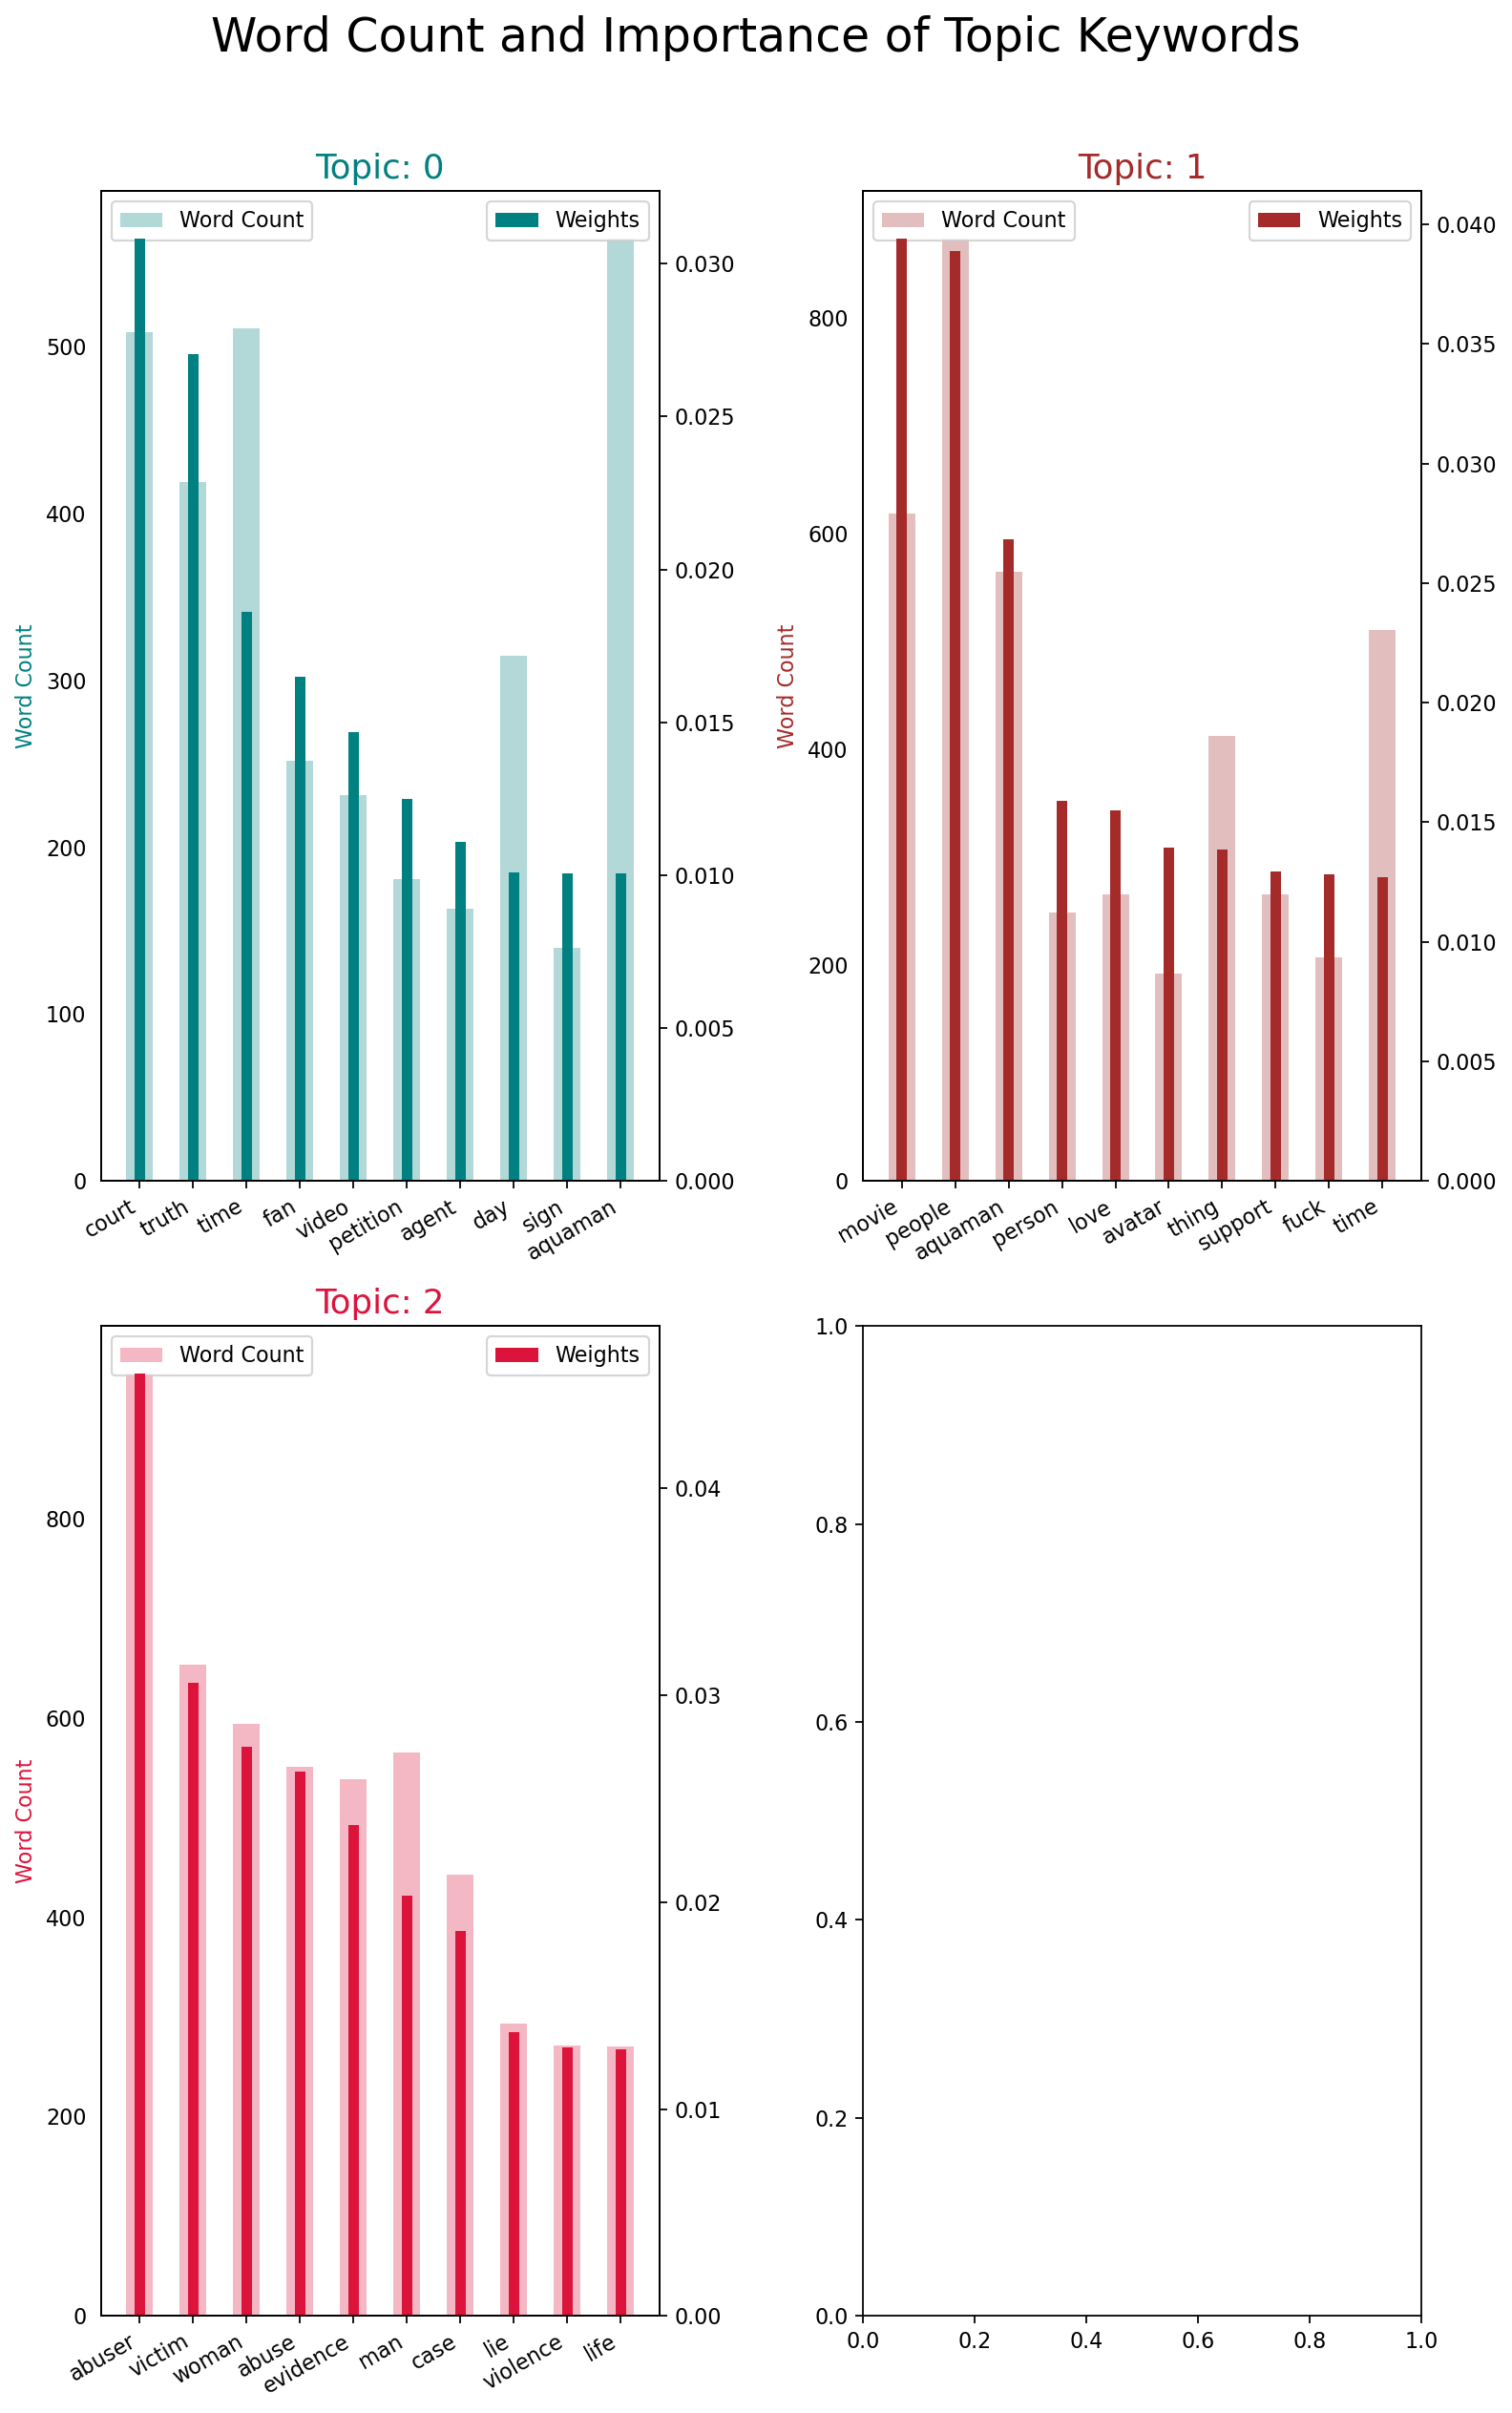

In [26]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
